# Mode-Turbulence Coupling: Numerical Analysis

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from scipy import integrate
import random
from scipy.integrate import quad
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import math
import scipy.interpolate as interpolate

## Parameters

In [2]:
n_bins=40

Tr =2*np.pi

#variables for generating F1
meanF1 = 0
stdF1 =.3

#variables for generating F2

stdF2 =.09
meanF2=0


## Functions

In [3]:
def rayleighdistribution():

    rayleigh = np.random.rayleigh(2*np.pi, 1000)
    count, bins, ignored = plt.hist(rayleigh, 80, density=True)
    plt.title("Rayleigh Distribution")
    plt.xlabel("Delta T")
    plt.show()
    
# Source: https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.rayleigh.html

def fundeltaT(n_bins, n_samples):
    rayleigh = np.random.rayleigh(2*np.pi, 1000)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    r = np.random.rand(n_samples)
    deltaT=inv_cdf(r)
    return deltaT

# Source: https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/

# Tturb adds up the delta T's

def funTturb():
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    return Tturb

# t is the sum of half way points of consecutive delta T's

def funt():
    t=[]
    for i in range(len(deltaT)-1):
        t.append((deltaT[i])/2+(deltaT[i+1])/2)
    return t

def funF1(meanF1, stdF1, Tr):

    y1=.1
    F1=[]
    prob=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF1**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F1.append(meant-stdevt+2*stdevt*R)
    return F1

def funF2(meanF2, stdF2, Tr):

    y1=.01
    F2=[]

    for i in range(len(t)):
        arr=[]
        a=t[i]
        stdevt=((1-math.exp(-2*a/Tr))*stdF2**2)**(1/2)
        meant=math.exp(-a/Tr)*y1
        R=random.uniform(0,1)
        F2.append(meant-stdevt+2*stdevt*R)
    return F2

#To Generate G1, I take the derivative of F1 by taking the difference of F1 values at times halfway between consecutive delta T's and divide that by the difference in those times

def funG1():

    G1=[0]
    for i in range(len(F1)-1):
        G1.append((F1[i+1]-F1[i])/(deltaT[i]+deltaT[i+1]))
    return G1

#F2=constant=c
#1+G1=constant=b
#F1=constant=a

def funAmp(dAdT, AT):

    A=[]
    t=[]
    derivA=[]
    ## a**2<4*b is always the case
    for i in range(len(Tturb)-1):
        a=F1[i]
        b=G1[i]+1
        c=F2[i]
        Ttemp=np.linspace(Tturb[i], Tturb[i+1])
        q=1/2*(4*b-a**2)**(1/2)
        C0=(math.exp(a*Tturb[i]/2)*dAdT+(a/2+q*math.tan(q*Tturb[i]))*(AT-c/b)*(math.exp(a*Tturb[i]/2)))*(math.cos(q*Tturb[i])/q)
        C1=(AT-c/b)*math.exp(a*Tturb[i]/2)/math.cos(q*Tturb[i])-C0*math.tan(q*Tturb[i])
        for j in Ttemp:
            if j==Tturb[i]:
                pass
            else:
                t.append(j)
                A.append(math.exp(-a*j/2)*(C0*math.sin(q*j)+C1*math.cos(q*j))+c/b)
                derivA.append(math.exp(-a*j/2)*(-a/2*(C0*math.sin(q*j)+C1*math.cos(q*j))+q*C0*math.cos(q*j)-q*C1*math.sin(q*j)))
        dAdT=derivA[-1]
        AT=A[-1]
    
    return A, t

In [4]:
def FunavgA(A):
    Asqr=[]
    for i in A:
        Asqr.append(i**2)
    avg=sum(Asqr)/len(Asqr)
    return avg

def FunLog(A):
    logA=[]
    for i in A:
        logA.append(math.log10(abs(i)))
    return logA

## Store values of F1, G1, F2, and \Delta T,  & compare two evolutions with different initial conditions

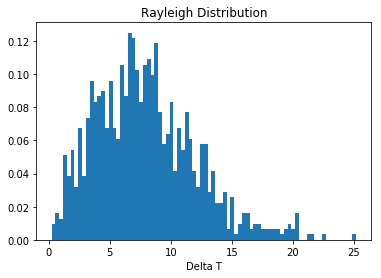

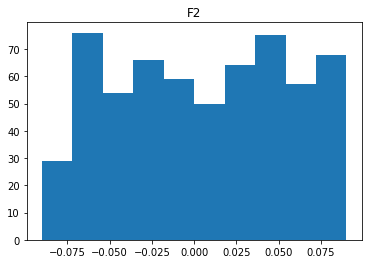

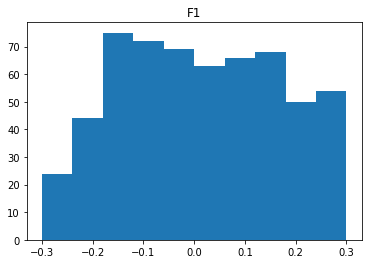

<F1^2>^(1/2) =  0.1620418942877181


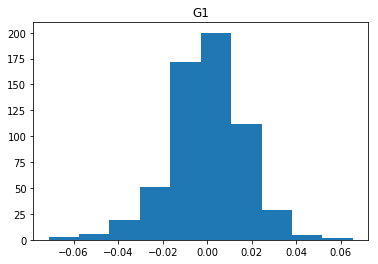

In [8]:
rayleighdistribution()

#n_samples is the number of eddy turnovers
n_samples=600

deltaT=fundeltaT(n_bins, n_samples)

Tturb=funTturb()

t=funt()

F2=funF2(meanF2, stdF2, Tr)
plt.hist(F2, 10, range=(-stdF2, stdF2))
plt.title("F2")
plt.show()

F1=funF1(meanF1, stdF1, Tr)
plt.hist(F1, 10, range=(-stdF1, stdF1))
plt.title("F1")
plt.show()

F1sqr=[]
for i in range(len(F1)):
    F1sqr.append(F1[i]**2)
rms=(sum(F1sqr) / len(F1sqr) )**(1/2)
print("<F1^2>^(1/2) = ", rms)
    

G1=funG1()
plt.hist(G1, 10)
plt.title("G1")
plt.show()

# A(0)=0, dA/dT(0)=0

In [9]:
#initial conditions A(0)=0, dA/dT(0)=0

dAdT=0
AT=0

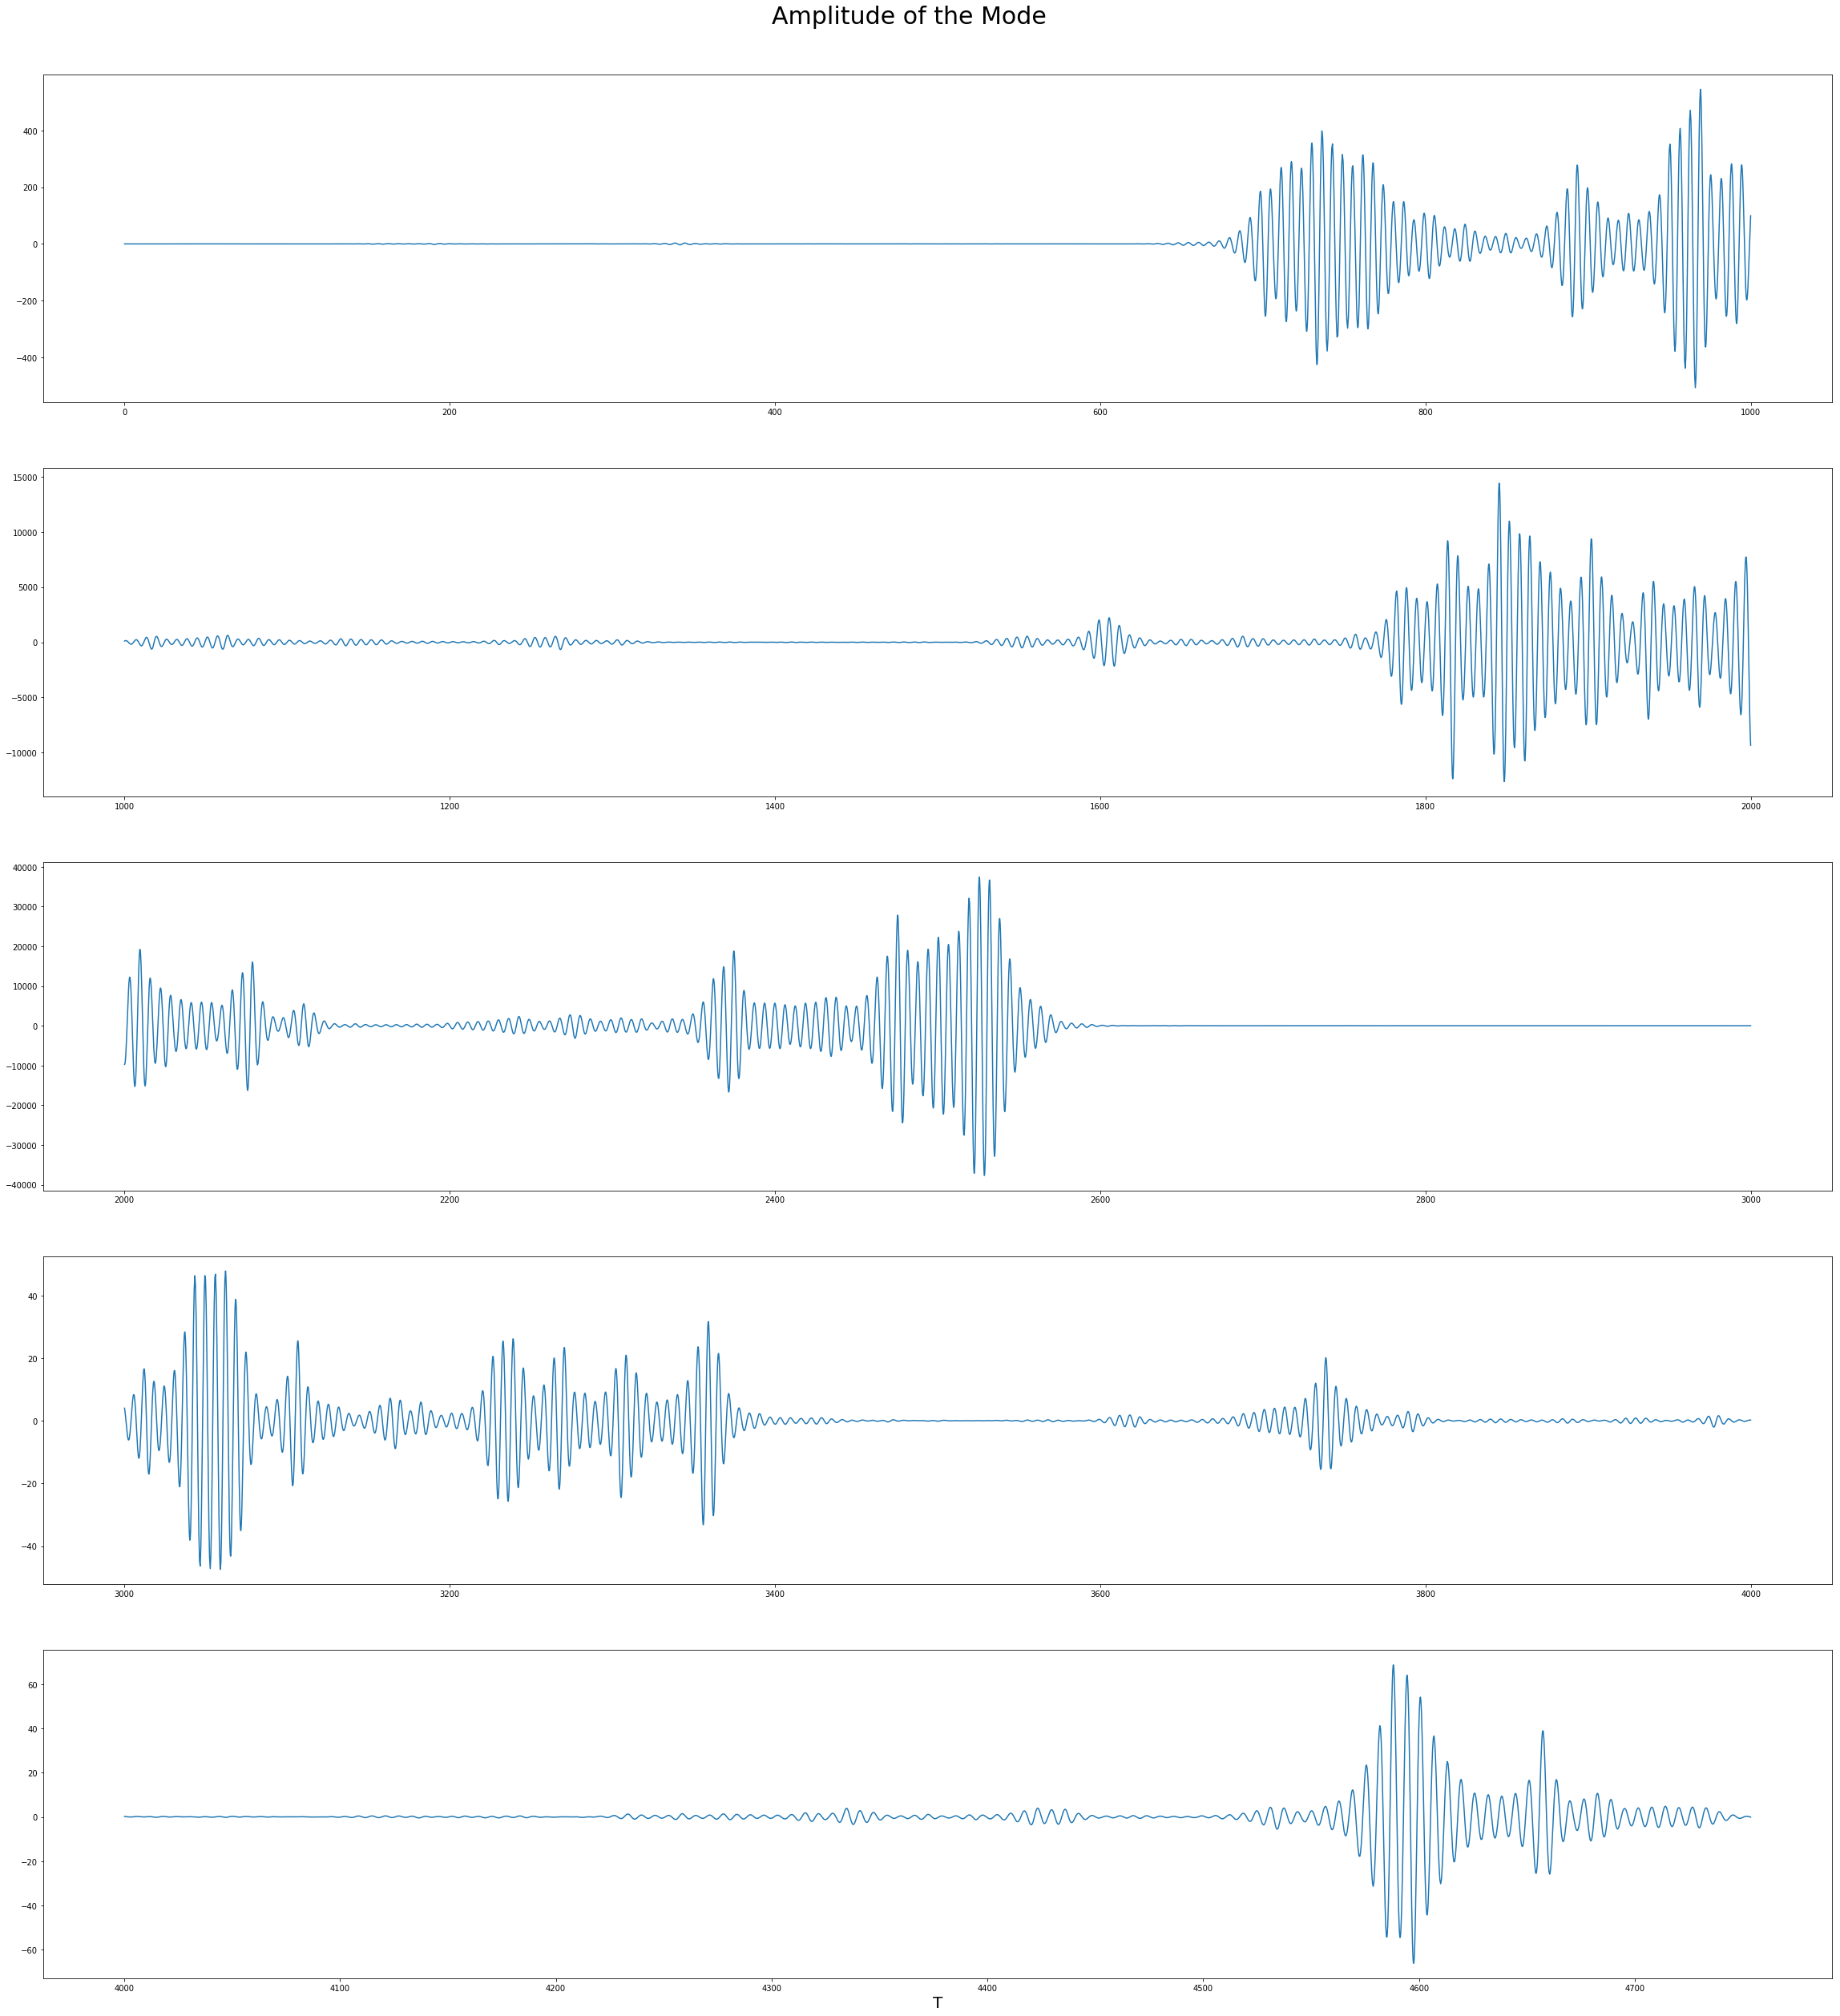

Amplitude of mode for 600 eddy turnovers

 Average value of the amplitude squared = 8425531.425730662


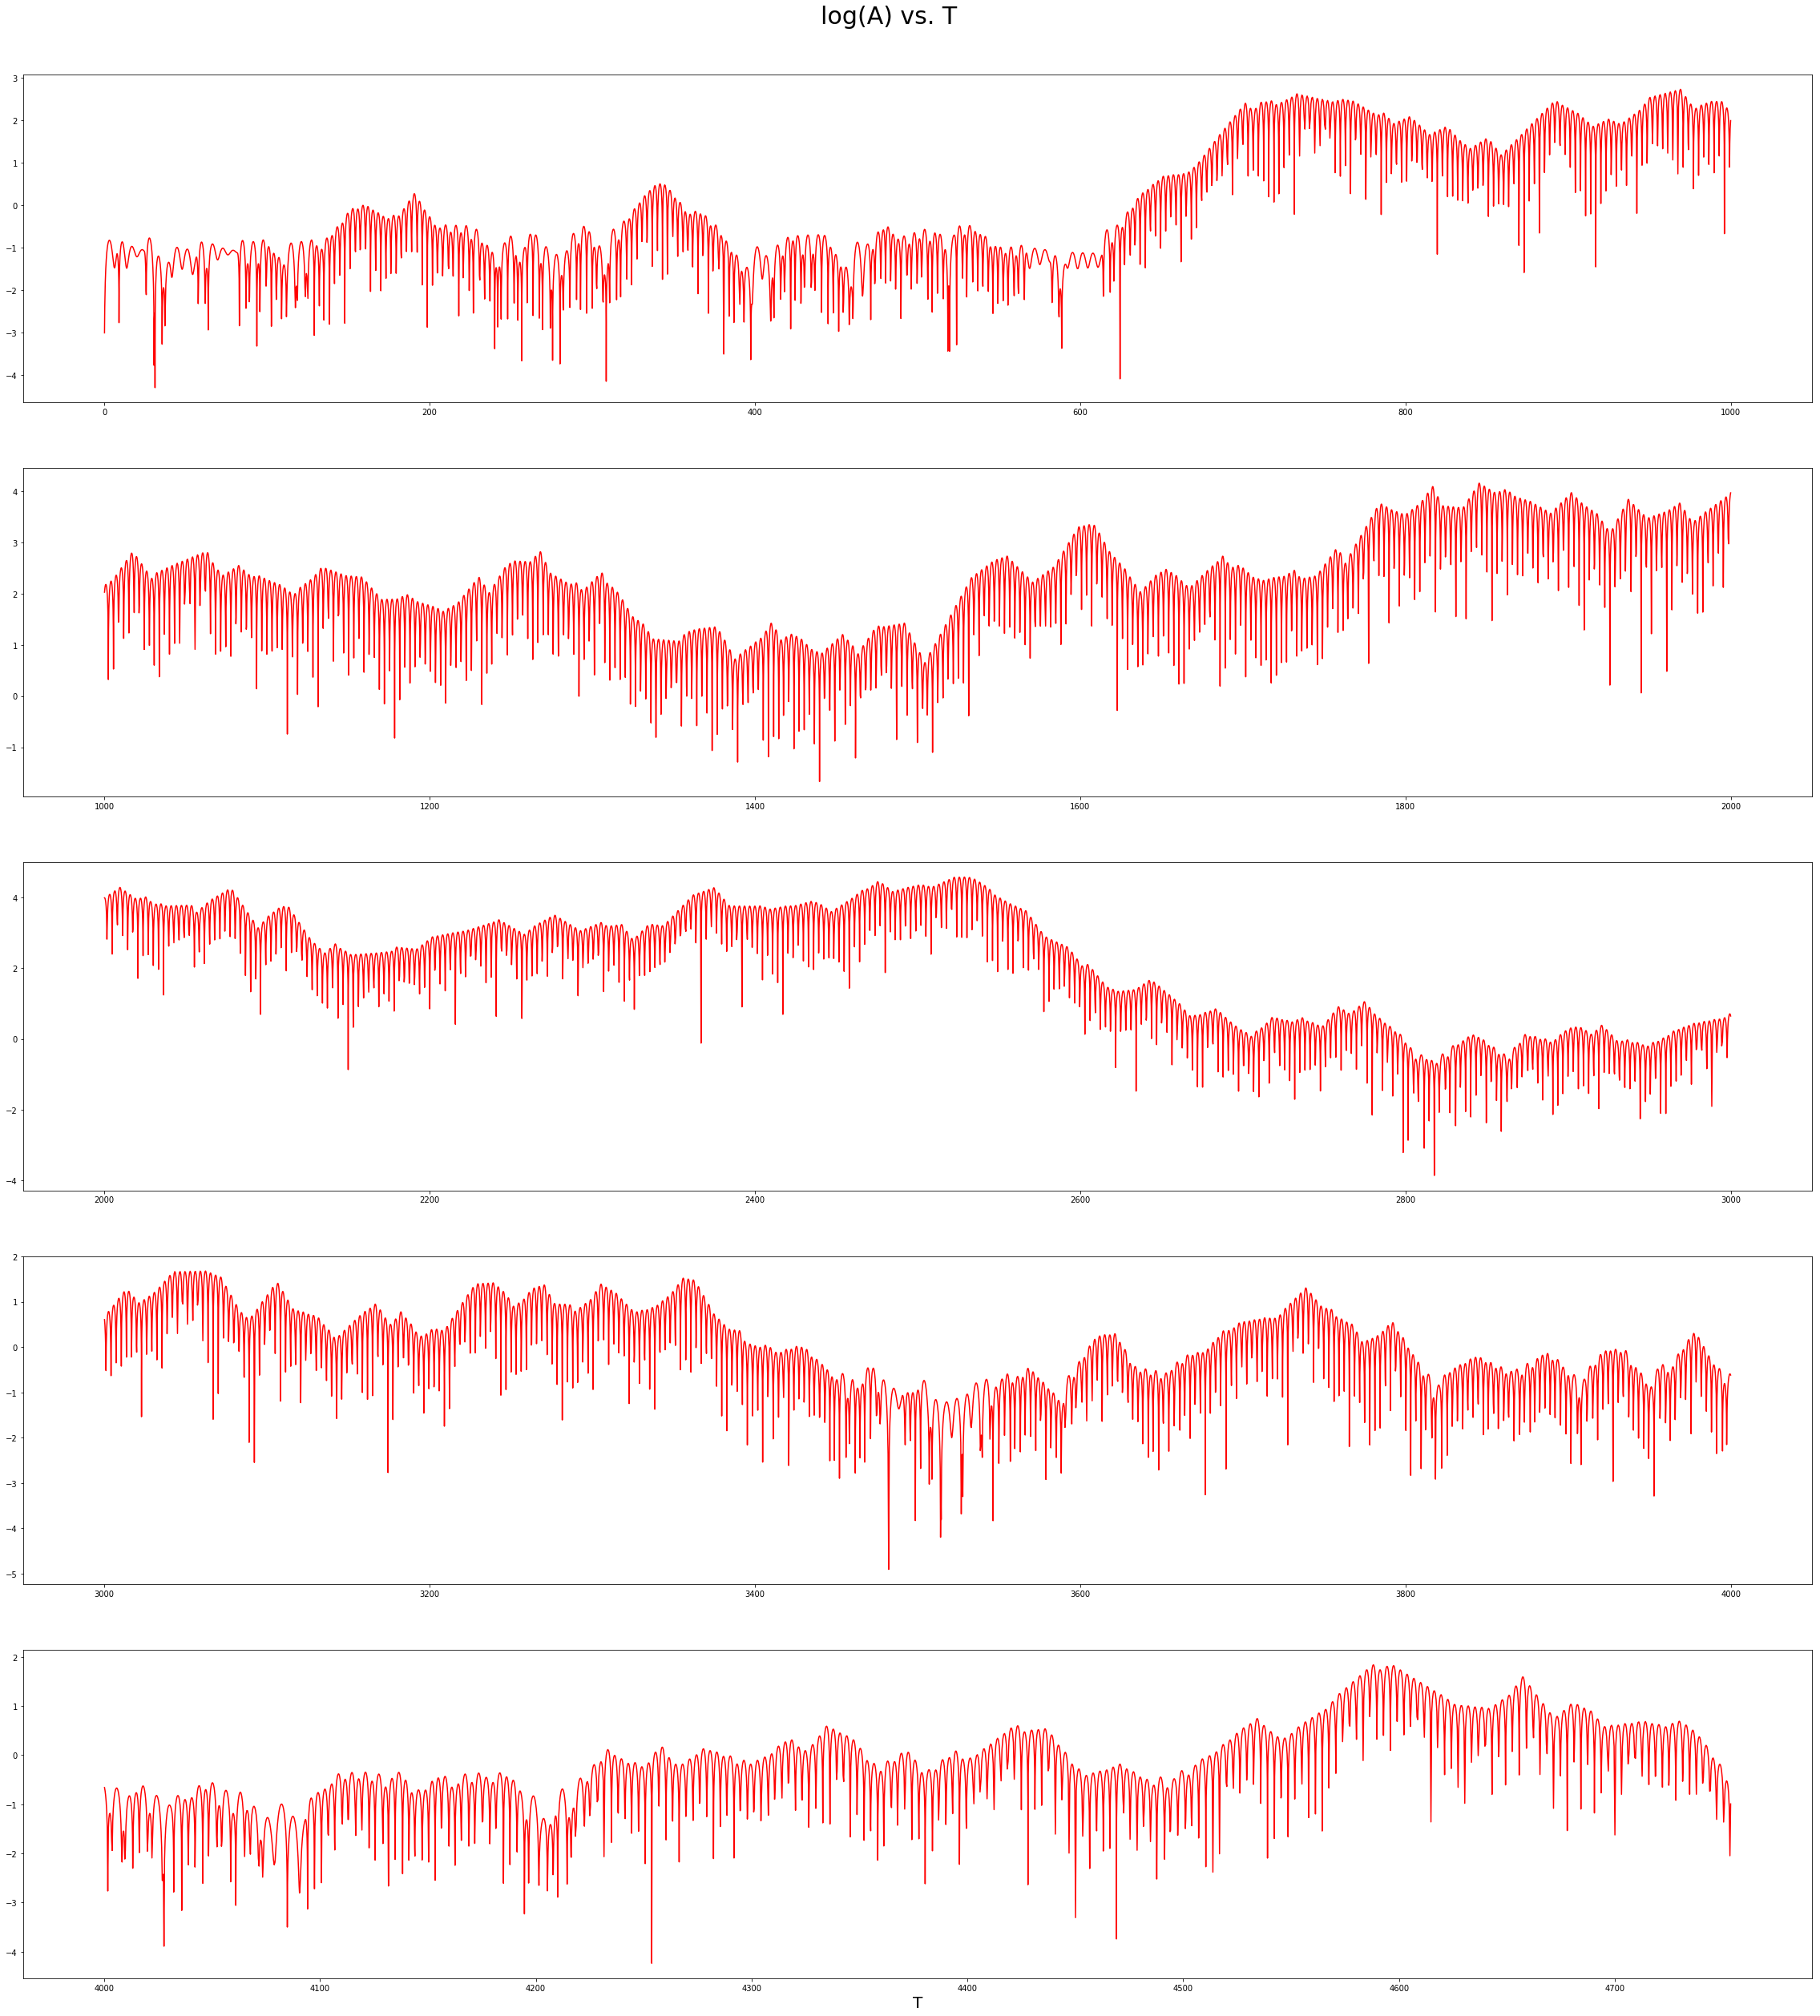

In [10]:
A, t =funAmp(dAdT, AT)
logA=FunLog(A)


A1=[]; A2=[]; A3=[]; A4=[]; A5=[]; A6=[]; 
t1=[]; t2=[]; t3=[]; t4=[]; t5=[]; t6=[];
logA1=[]; logA2=[]; logA3=[]; logA4=[]; logA5=[]; logA6=[]; logA1=[]

for i in range(len(t)):
    if t[i]<=1000:
        t1.append(t[i])
        A1.append(A[i])
        logA1.append(logA[i])
    elif t[i]<=2000:
        t2.append(t[i])
        A2.append(A[i])
        logA2.append(logA[i])
    elif t[i]<=3000:
        t3.append(t[i])
        A3.append(A[i])
        logA3.append(logA[i])
    elif t[i]<=4000:
        t4.append(t[i])
        A4.append(A[i])
        logA4.append(logA[i])
    elif t[i]<=5000:
        t5.append(t[i])
        A5.append(A[i])
        logA5.append(logA[i])
    elif t[i]<=6000:
        t6.append(t[i])
        A6.append(A[i])
        logA6.append(logA[i])
        
fig, axs = plt.subplots(5, figsize=(40,40))
fig.suptitle('Amplitude of the Mode', fontsize=30)
plt.xlabel('T', fontsize=20)
axs[0].plot(t1, A1)
axs[1].plot(t2, A2)
axs[2].plot(t3, A3)
axs[3].plot(t4, A4)
axs[4].plot(t5, A5)
#axs[5].plot(t6, A6)
plt.subplots_adjust(top=0.95)
plt.show()

avg=FunavgA(A)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("\n Average value of the amplitude squared =", avg)


fig, axs = plt.subplots(5, figsize=(40,40))
fig.suptitle('log(A) vs. T', fontsize=30)
plt.xlabel('T', fontsize=20)
axs[0].plot(t1, logA1, color='red')
axs[1].plot(t2, logA2, color='red')
axs[2].plot(t3, logA3,color='red')
axs[3].plot(t4, logA4, color='red')
axs[4].plot(t5, logA5, color='red')
#axs[5].plot(t6, logA6, color='red')
plt.subplots_adjust(top=0.95)
plt.show()

# A(0)=0.001, dA/dT(0)=.001/6

In [11]:
#initial conditions A(0)=0, dA/dT(0)=0

AT=0.001
dAdT=AT/6


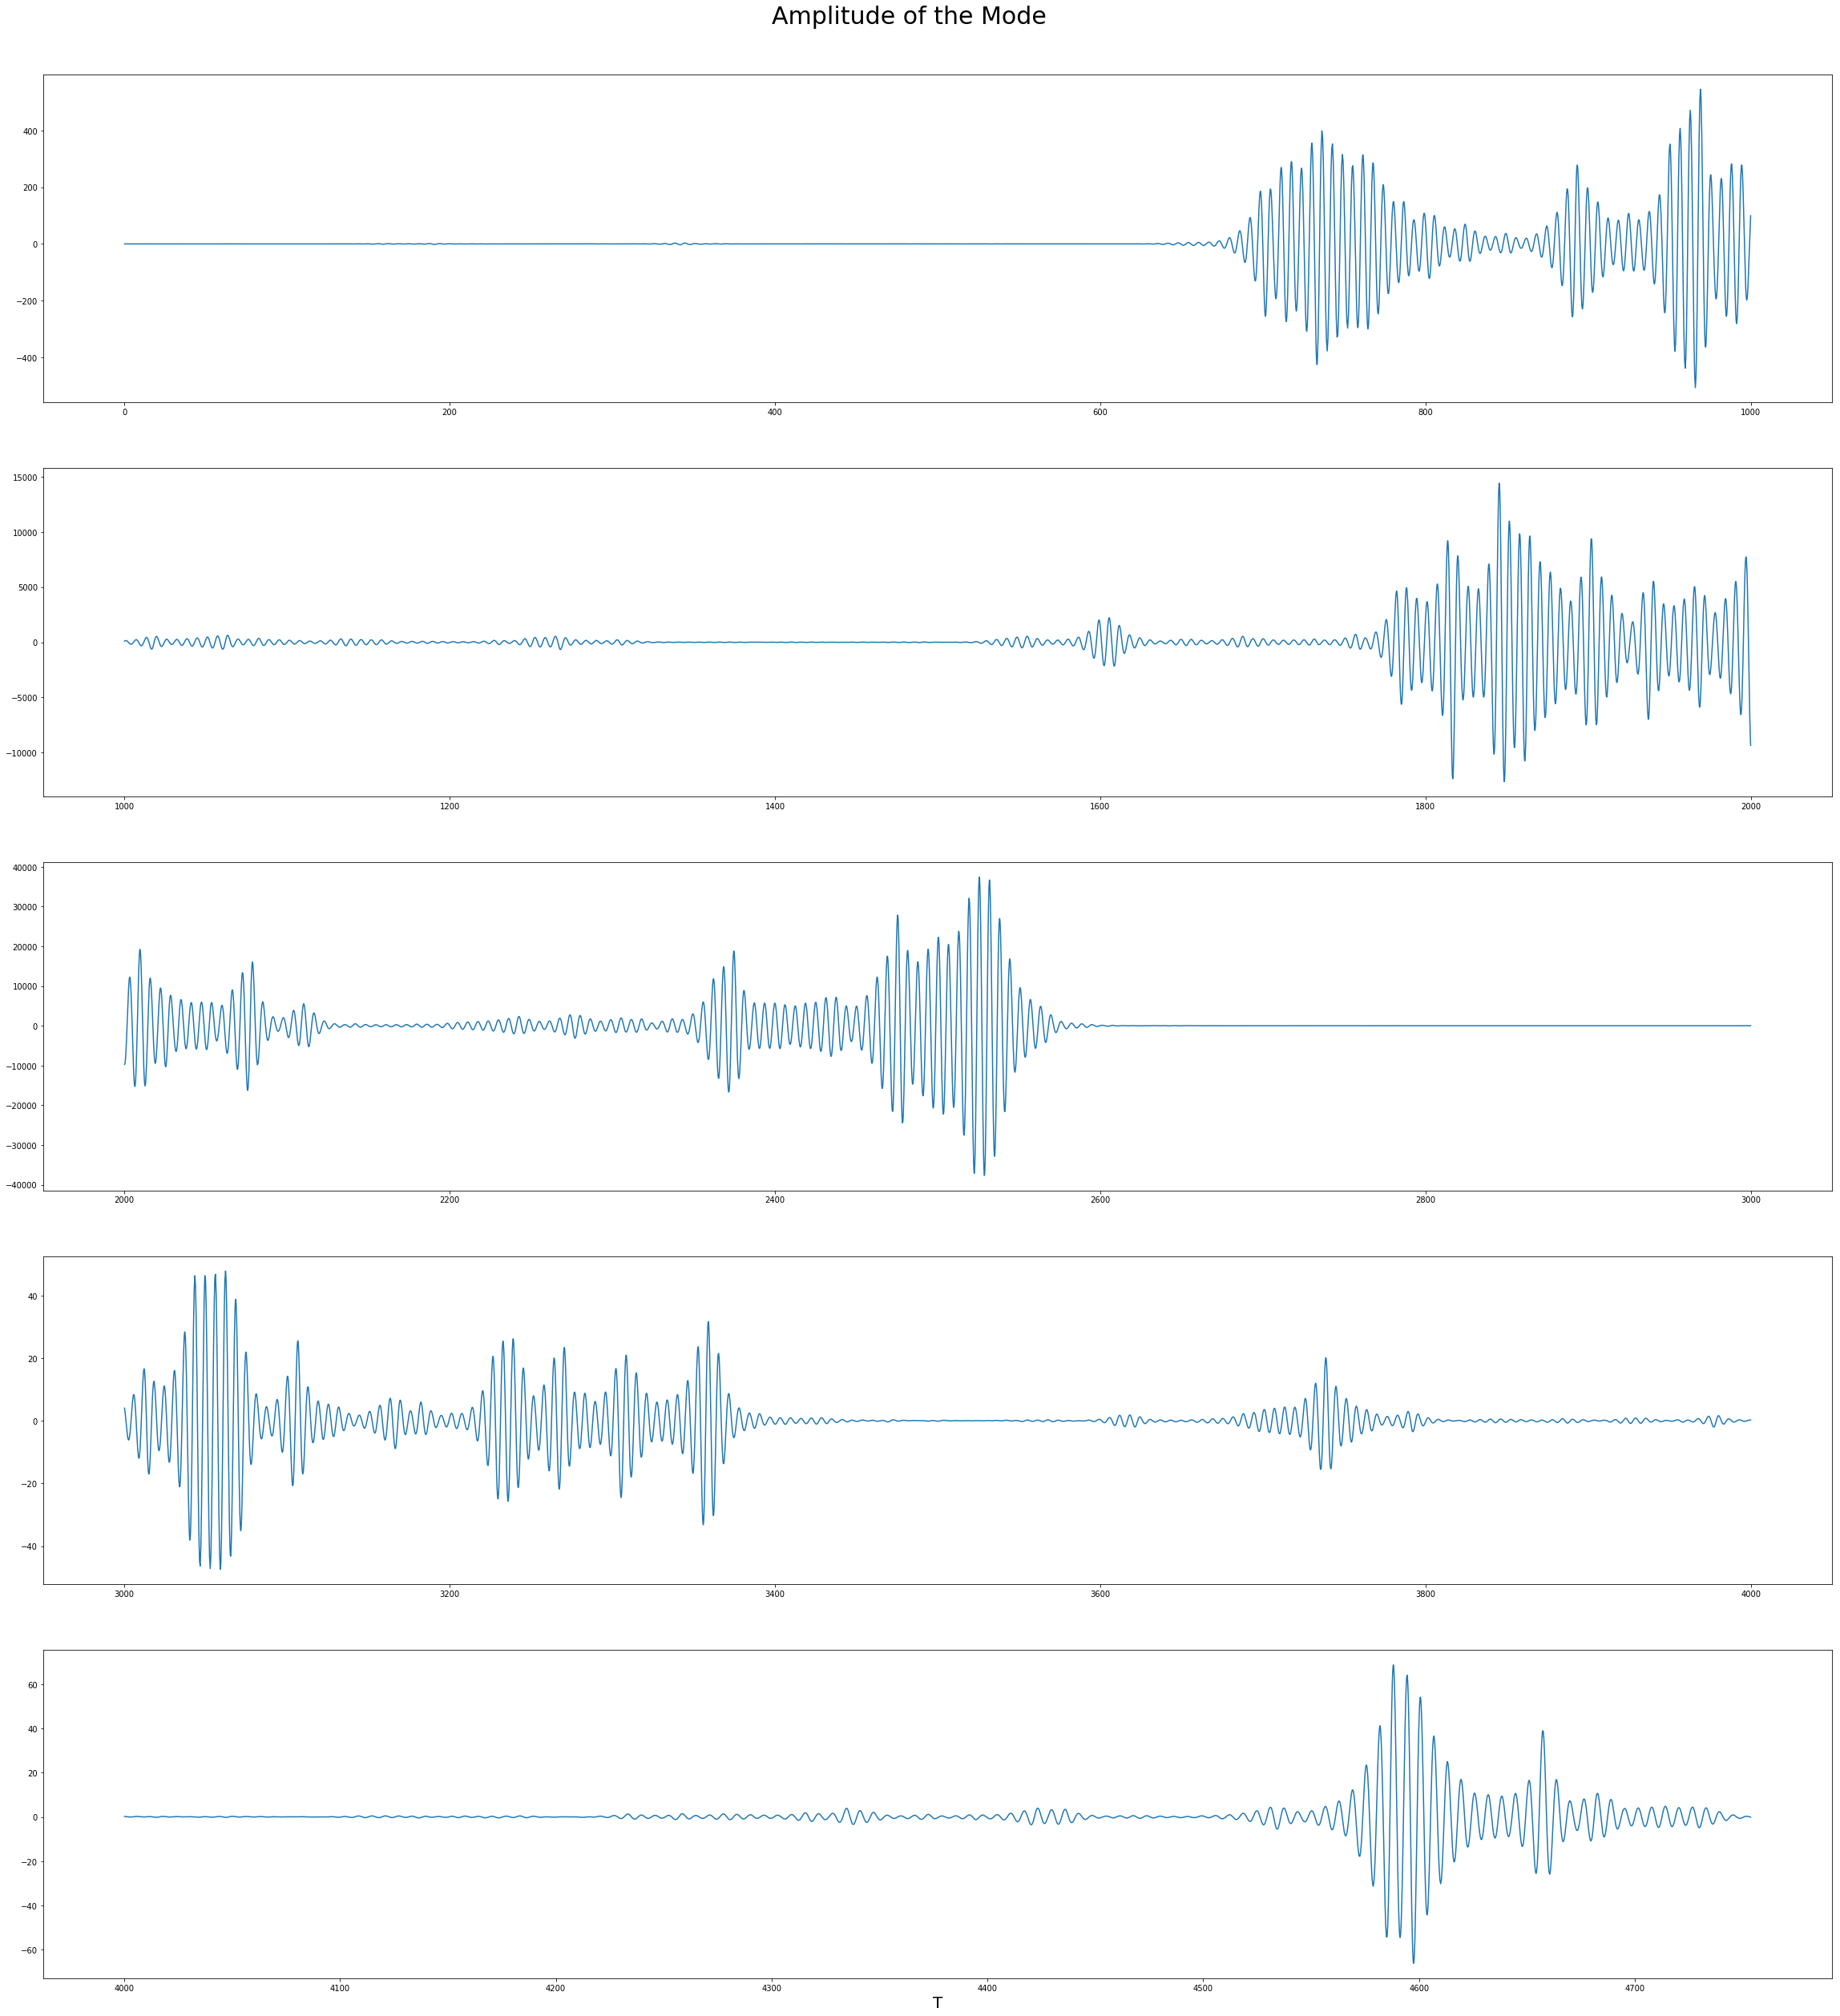

Amplitude of mode for 600 eddy turnovers

 Average value of the amplitude squared = 8425531.424941963


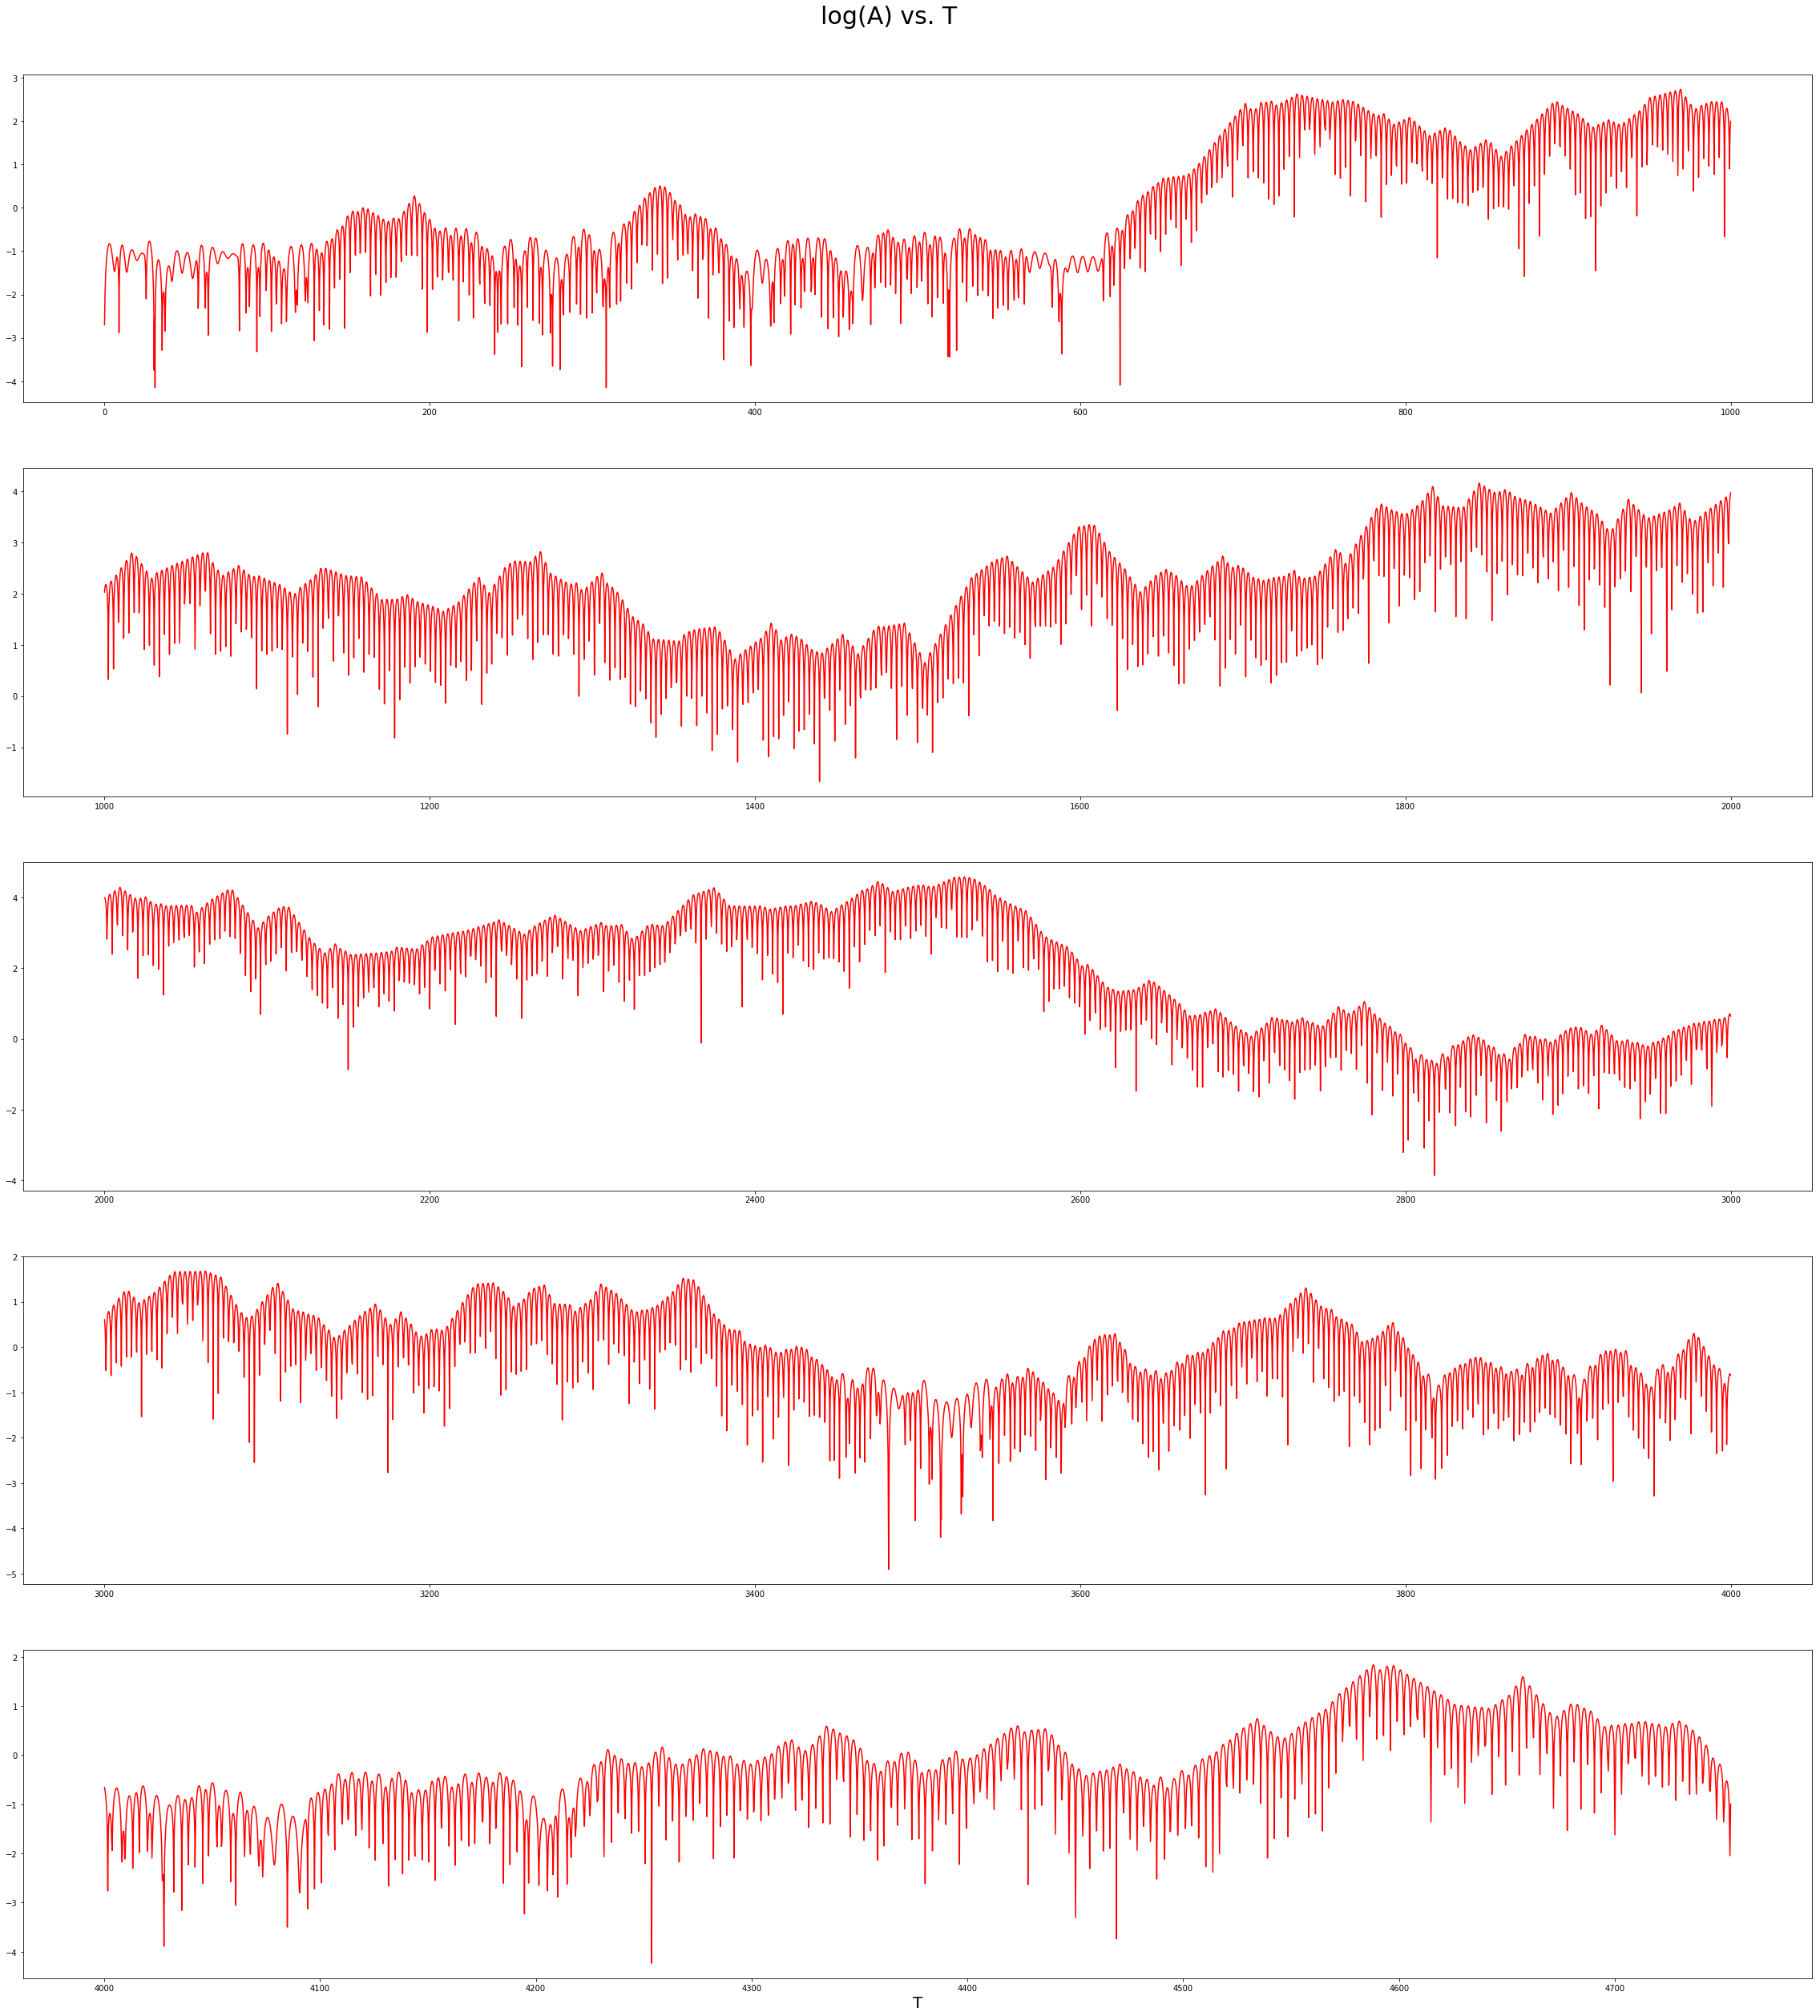

In [12]:
A, t =funAmp(dAdT, AT)
logA=FunLog(A)


A1=[]; A2=[]; A3=[]; A4=[]; A5=[]; A6=[]; 
t1=[]; t2=[]; t3=[]; t4=[]; t5=[]; t6=[];
logA1=[]; logA2=[]; logA3=[]; logA4=[]; logA5=[]; logA6=[]; logA1=[]

for i in range(len(t)):
    if t[i]<=1000:
        t1.append(t[i])
        A1.append(A[i])
        logA1.append(logA[i])
    elif t[i]<=2000:
        t2.append(t[i])
        A2.append(A[i])
        logA2.append(logA[i])
    elif t[i]<=3000:
        t3.append(t[i])
        A3.append(A[i])
        logA3.append(logA[i])
    elif t[i]<=4000:
        t4.append(t[i])
        A4.append(A[i])
        logA4.append(logA[i])
    elif t[i]<=5000:
        t5.append(t[i])
        A5.append(A[i])
        logA5.append(logA[i])
    elif t[i]<=6000:
        t6.append(t[i])
        A6.append(A[i])
        logA6.append(logA[i])
        
fig, axs = plt.subplots(5, figsize=(40,40))
fig.suptitle('Amplitude of the Mode', fontsize=30)
plt.xlabel('T', fontsize=20)
axs[0].plot(t1, A1)
axs[1].plot(t2, A2)
axs[2].plot(t3, A3)
axs[3].plot(t4, A4)
axs[4].plot(t5, A5)
#axs[5].plot(t6, A6)
plt.subplots_adjust(top=0.95)
plt.show()

avg=FunavgA(A)

print("Amplitude of mode for" , n_samples, "eddy turnovers")
print("\n Average value of the amplitude squared =", avg)


fig, axs = plt.subplots(5, figsize=(40,40))
fig.suptitle('log(A) vs. T', fontsize=30)
plt.xlabel('T', fontsize=20)
axs[0].plot(t1, logA1, color='red')
axs[1].plot(t2, logA2, color='red')
axs[2].plot(t3, logA3,color='red')
axs[3].plot(t4, logA4, color='red')
axs[4].plot(t5, logA5, color='red')
#axs[5].plot(t6, logA6, color='red')
plt.subplots_adjust(top=0.95)
plt.show()